# Chapter 12 - Exercise Solutions - Applied

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from statsmodels.datasets import get_rdataset
from ISLP import load_data

from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
# from sklearn.cluster import KMeans
# from scipy.cluster.hierarchy import cut_tree
from ISLP.cluster import compute_linkage

np.get_printoptions() # 75 default
np.set_printoptions(linewidth=300)

## 7

In this chapter, we mentioned the use of correlation-based distance and Euclidean distance as dissimilarity measures for hierarchical clustering. It turns out that these two measures are almost equivalent: if each observation has been centered to have mean zero and standard deviation one, and if we let $r_{ij}$ denote the correlation between the $i_{th}$ and $j_{th}$ observations, then the quantity $1 − r_{ij}$ is proportional to the squared Euclidean distance between the $i_{th}$ and $j_{th}$ observations.

On the `USArrests` data, show that this proportionality holds.

*Hint:* The Euclidean distance can be calculated using the `pairwise_distances()` function from the `sklearn.metrics` module, and correlations can be calculated using the `np.corrcoef()` function.

In [12]:
USArrests = get_rdataset('USArrests').data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [116]:
scaler = StandardScaler(with_std=True, with_mean=True)
USArrests_scaled = scaler.fit_transform(USArrests.T).T # Transpose to normalize across features (not observations)
USArrests_scaled.shape

(50, 4)

In [91]:
corr_matrix = np.corrcoef(USArrests_scaled) # Correlation between observations (rows of x)
corr_matrix

array([[1.        , 0.99092502, 0.99856984, ..., 0.96759749, 0.58753266, 0.98911539],
       [0.99092502, 1.        , 0.98969621, ..., 0.93489972, 0.51058785, 0.96749454],
       [0.99856984, 0.98969621, 1.        , ..., 0.97553899, 0.61849688, 0.99361584],
       ...,
       [0.96759749, 0.93489972, 0.97553899, ..., 1.        , 0.7724072 , 0.99407361],
       [0.58753266, 0.51058785, 0.61849688, ..., 0.7724072 , 1.        , 0.7001675 ],
       [0.98911539, 0.96749454, 0.99361584, ..., 0.99407361, 0.7001675 , 1.        ]])

In [101]:
eucdist_appx = np.sqrt(1 - corr_matrix)
eucdist_appx

array([[1.49011612e-08, 9.52626680e-02, 3.78174278e-02, ..., 1.80006984e-01, 6.42236202e-01, 1.04329324e-01],
       [9.52626680e-02, 1.49011612e-08, 1.01507591e-01, ..., 2.55147560e-01, 6.99579980e-01, 1.80292712e-01],
       [3.78174278e-02, 1.01507591e-01, 1.49011612e-08, ..., 1.56400161e-01, 6.17659386e-01, 7.99009508e-02],
       ...,
       [1.80006984e-01, 2.55147560e-01, 1.56400161e-01, ..., 1.49011612e-08, 4.77066870e-01, 7.69830457e-02],
       [6.42236202e-01, 6.99579980e-01, 6.17659386e-01, ..., 4.77066870e-01, 0.00000000e+00, 5.47569632e-01],
       [1.04329324e-01, 1.80292712e-01, 7.99009508e-02, ..., 7.69830457e-02, 5.47569632e-01, 1.49011612e-08]])

In [102]:
eucdist = pairwise_distances(USArrests_scaled, metric='euclidean')
eucdist

array([[0.        , 0.26944351, 0.10696384, ..., 0.50913664, 1.81651829, 0.29508789],
       [0.26944351, 0.        , 0.28710682, ..., 0.72166628, 1.97871099, 0.5099448 ],
       [0.10696384, 0.28710682, 0.        , ..., 0.44236646, 1.74700456, 0.22599402],
       ...,
       [0.50913664, 0.72166628, 0.44236646, ..., 0.        , 1.34934887, 0.21774093],
       [1.81651829, 1.97871099, 1.74700456, ..., 1.34934887, 0.        , 1.5487608 ],
       [0.29508789, 0.5099448 , 0.22599402, ..., 0.21774093, 1.5487608 , 0.        ]])

In [94]:
eucdist/eucdist_appx

/var/folders/04/x6phf57n2c7d0_05mhjff6cm0000gn/T/ipykernel_47194/2371874435.py:1: RuntimeWarning: invalid value encountered in divide
  eucdist/eucdist_appx


array([[0.        , 2.82842712, 2.82842712, ..., 2.82842712, 2.82842712, 2.82842712],
       [2.82842712, 0.        , 2.82842712, ..., 2.82842712, 2.82842712, 2.82842712],
       [2.82842712, 2.82842712, 0.        , ..., 2.82842712, 2.82842712, 2.82842712],
       ...,
       [2.82842712, 2.82842712, 2.82842712, ..., 0.        , 2.82842712, 2.82842712],
       [2.82842712, 2.82842712, 2.82842712, ..., 2.82842712,        nan, 2.82842712],
       [2.82842712, 2.82842712, 2.82842712, ..., 2.82842712, 2.82842712, 0.        ]])

In [115]:
I = np.identity(USArrests.shape[0])
ones = np.ones((USArrests.shape[0],USArrests.shape[0]))

offset = (( (eucdist + I) / (eucdist_appx + I) ) - I )/2.82842712 + I # Extra Is to avoid div by 0; should me a (n x n) matrix of ones
np.allclose(offset, ones)

True

For this dataset, the proportionality holds; the approximation is offset by a proportional factor of 2.82842712.

## 8

In Section 12.2.3, a formula for calculating PVE was given in Equation 12.10. We also saw that the PVE can be obtained using the `explained_variance_ratio_` attribute of a fitted `PCA()` estimator.

On the `USArrests` data, calculate PVE in two ways:



**(a)** Using the `explained_variance_ratio_` output of the fitted `PCA()` estimator, as was done in Section 12.2.3.

In [133]:
USArrests = get_rdataset('USArrests').data
scaler = StandardScaler(with_std=True, with_mean=True)
X = scaler.fit_transform(USArrests)

In [134]:
pcaUS = PCA()
pcaUS.fit(X)

PCA()

In [135]:
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

**(b)** By applying Equation 12.10 directly. The loadings are stored as the `components_` attribute of the fitted `PCA()` estimator. Use those loadings in Equation 12.10 to obtain the PVE.

In [136]:
scores = pcaUS.transform(X) # 50x4
loadings = pcaUS.components_ # 4x4 Each row contains a principle componenet loading vector

$$ Z = \phi X $$

In [223]:
PVE = [0] * X.shape[1]

for m in range(0,X.shape[1]):

    num_arr = [0] * X.shape[0]
    for i in range(0,X.shape[0]):

        for j in range(0,X.shape[1]):
            num_arr[i] += loadings[m,j] * X[i,j] # Note dimensions are swapped for loadings[m,j] compared to textbook notation

    num = sum(np.array(num_arr)**2)

    den = 0
    for j in range(0,X.shape[1]):
        for i in range(0,X.shape[0]):
            den += X[i,j]**2

    # den = 

    PVE[m] = num/den
    
np.array(PVE)

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

The results are identical.

Alternatively, using the PCE scores directly...

In [229]:
for m in range(0,X.shape[1]):
    num = np.sum(scores[:,m]**2)
    den = np.sum(X**2)
    print(num/den)

0.6200603947873737
0.24744128813496044
0.08914079514520752
0.04335752193245883


## 9

Consider the `USArrests` data. We will now perform hierarchical clustering on the states.

**(a)** Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states.

In [230]:
X = get_rdataset('USArrests').data

In [240]:
h_clust_complete = AgglomerativeClustering(metric='euclidean', distance_threshold=0, n_clusters=None, linkage='complete')
h_clust_complete.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='euclidean', n_clusters=None)

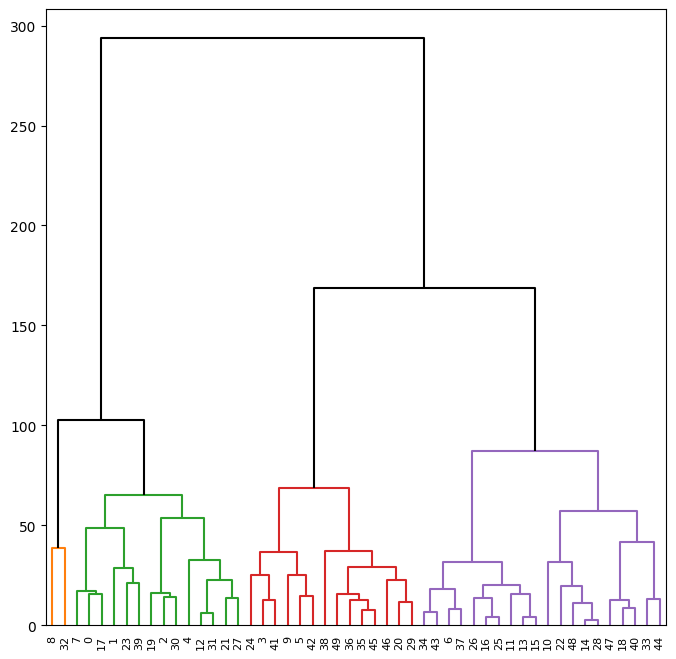

In [249]:
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=90,
           above_threshold_color='black'
           );

In [236]:
HClust = AgglomerativeClustering
hc_comp = HClust(metric='euclidean', distance_threshold=0, n_clusters=None, linkage='complete')
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='euclidean', n_clusters=None)